# Character level language model: Dinosaur names

In [1]:
import numpy as np
from utils import *
import copy

## <span style="color:blue"> Data & Preprocessing </span>

In [2]:
data = open('dinos.txt', 'r').read()
data = data.lower() # convert to lower case
chars = list(set(data)) # list of unique characters in the dataset
data_size, char_size = len(data), len(chars)
print(f"There are {data_size} total characters and {char_size} unique characters in the data")

There are 19909 total characters and 27 unique characters in the data


In [3]:
print(f"The unique characters are\n{chars}")

The unique characters are
['m', 'v', 'y', 'u', '\n', 'r', 'j', 'h', 'b', 'l', 'f', 'k', 'g', 'e', 'd', 'q', 'x', 'p', 'z', 'i', 'a', 's', 'n', 'o', 't', 'c', 'w']


**Notes:**
- The dataset is treated as one continuous list of characters including an end of line (i.e., dinosaur name) token `\n`.
- Below we create two hashmaps to map each character to an index $0,1,\dots,26$ and vise versa.

In [4]:
chars = sorted(chars)
char_to_index = {char:index for index, char in enumerate(chars)}
index_to_char = {index:char for index, char in enumerate(chars)}
import pprint
pp = pprint.PrettyPrinter(indent=2)
print(f"char_to_index:")
pp.pprint(char_to_index)
print(f"index_to_char:")
pp.pprint(index_to_char)

char_to_index:
{ '\n': 0,
  'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26}
index_to_char:
{ 0: '\n',
  1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z'}


## <span style="color:blue"> Random sampling from the trained model </span>
Assume that our model is trained. The goal is to use this trained model to sample random dinosaur names! The procedue is shown below:

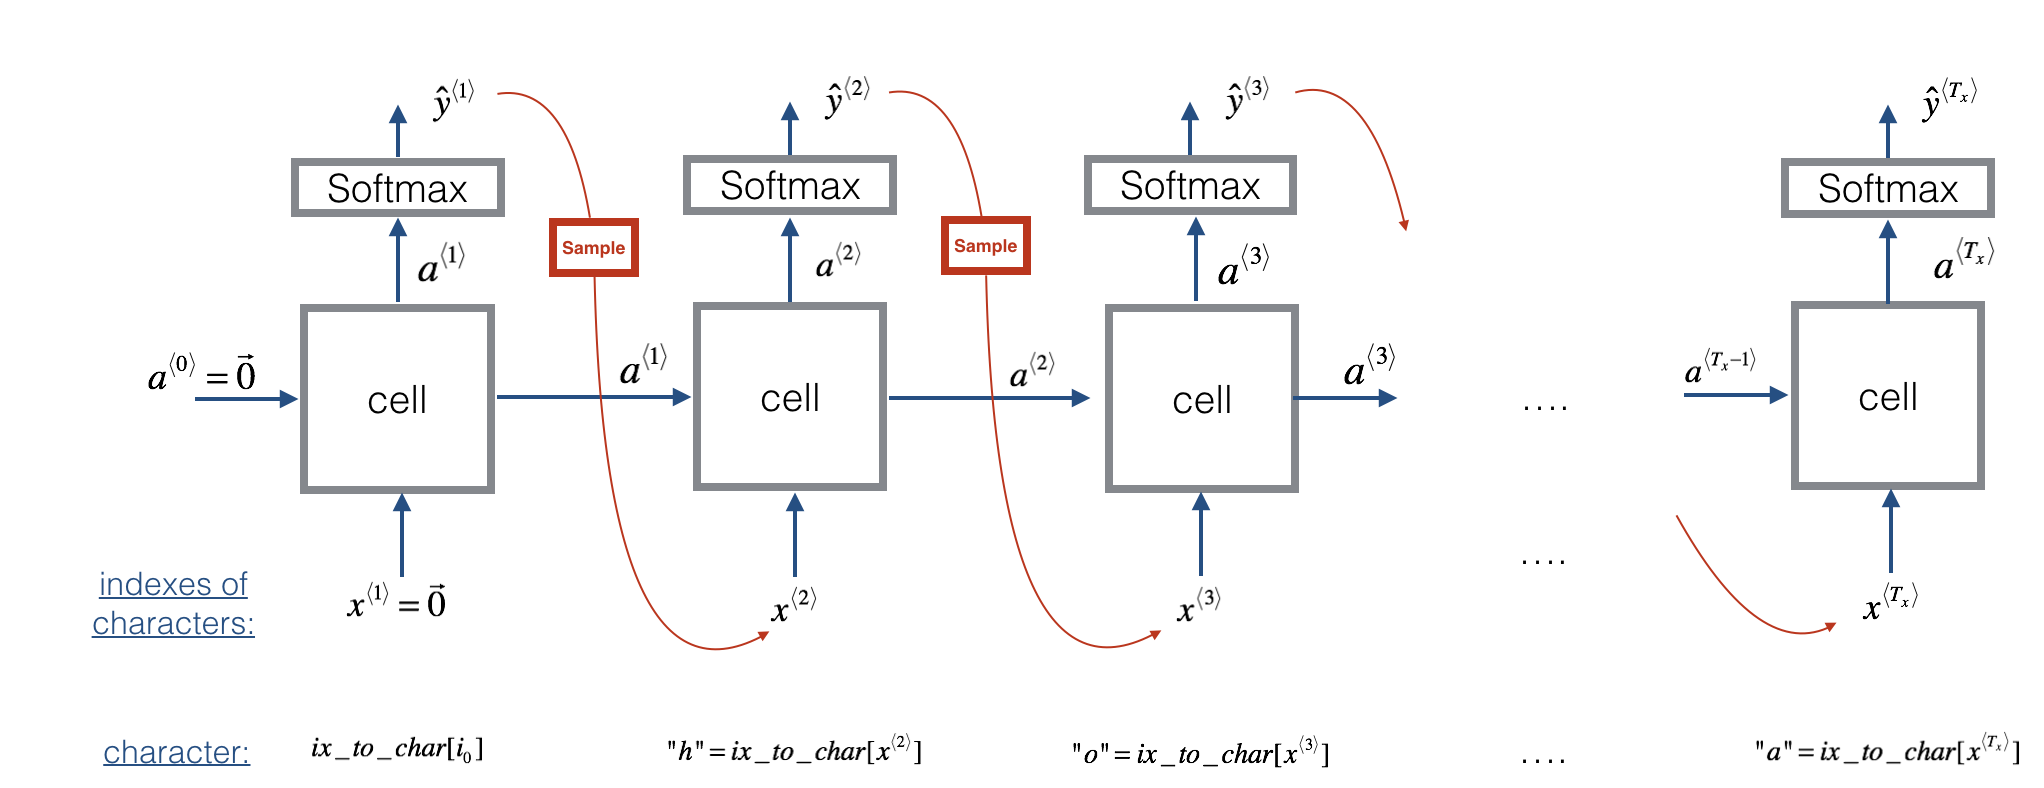

<center> image taken directly from the course site </center>

**Notes:**
- Prediction of each block $t$, denoted by $\hat{y}^{\langle t\rangle}$, is used to sample the next character input $x^{\langle t+1\rangle}$.
- The first character input $x^{\langle 1\rangle}$ and hidden state activation $a^{\langle 0\rangle}$ are both initialized to zero vectors.
- We use traditional RNN blocks.

Each RNN block includes the following calculations:
$$a^{\langle t\rangle}=\tanh\left(W_{ax}x^{\langle t\rangle}+W_{aa}a^{\langle t-1\rangle}+b_a\right)$$
$$\hat{y}^{\langle t\rangle}=\mathrm{softmax}\left(W_{ya}a^{\langle t\rangle}+b_y\right)$$

**Shapes:**
- $x^{\langle t\rangle}$, $\hat{y}^{\langle t\rangle}$, and $a^{\langle t+1\rangle}$ have shapes $(n_x,1)$, $(n_y,1)$, and $(n_a,1)$, respectively. Note that during training we usually have these data in batches and the second dimenion denotes the number of training examples in a batch, e.g., $x^{\langle t\rangle}.\mathrm{shape}=(n_x,m)$.
- Weight matrices $W_{ax}$, $W_{aa}$, and $W_{ya}$ have shapes $(n_a,n_x)$, $(n_a,n_a)$, and $(n_y,n_a)$, respectively.
- Bias terms $b_a$ and $b_y$ are vectotors with size $n_a$ and $n_y$, respectivley.

**Sampling:**
If we always select the character with the highest probability, the result will be the same, given the same character. To make it more interesting we `np.random.choice` to select the next layer using a probability distribution given by the entries of $\hat{y}^{\langle t\rangle}$. Eventually, a random choice from $\hat{y}^{\langle 1\rangle}$ gives you the first character, a random choice from $\hat{y}^{\langle 2\rangle}$ gives you the second character, and so on.

In [5]:
from scipy.special import softmax
def sample(parameters, char_to_index, seed):
    """
    INPUT:
    parameters: hashmap:
                    Wax: shape = (n_a,n_x) 
                    Waa: shape = (n_a,n_a)
                    Wya: shape = (n_y,n_a)
                    ba:  shape = (n_a,1)
                    by:  shape = (n_y,1)
                    
    char_to_index: python dictionary mapping each character to an index

    OUTPUT:
    indices: a list of length T_x containing the indices of the sampled characters
    """
    
    Wax, Waa, Wya, ba, by = parameters['Wax'], parameters['Waa'], parameters['Wya'], parameters['ba'], parameters['by']
    n_a, n_x = Wax.shape
    n_y = by.shape[0]
    
    x = np.zeros((n_x,1))
    a_prev = np.zeros((n_a,1))
    
    max_num_chars = 50
    counter = 0
    newline_char_index = char_to_index['\n']
    indices = []# stores the index of the random choice from predictions yhat
    idx = -1
    while (idx != newline_char_index and counter != max_num_chars):
        
        a = np.tanh(np.dot(Wax,x)+np.dot(Waa,a_prev)+ba)
        z = np.dot(Wya,a)+by
        yhat = softmax(z,axis=0)
        
        np.random.seed(counter + seed)
        idx = np.random.choice(range(n_y),p=yhat.ravel()) # note that yhat.shape = (n_y,1) and we need to tranform it to a 1D vector with shape (n_y,)

        indices.append(idx)
        
        x = np.zeros((n_x,1))
        x[idx] = 1
        
        a_prev = a
        counter +=1
        
        seed += 1 # for testing

    if (counter == 50):
        indices.append(newline_char_index)
    
    return indices

In [6]:
# Tests taken directly from the course site with minor changes
def sample_test(target):
    np.random.seed(24)
    _, n_a = 20, 100
    Wax, Waa, Wya = np.random.randn(n_a, char_size), np.random.randn(n_a, n_a), np.random.randn(char_size, n_a)
    ba, by = np.random.randn(n_a, 1), np.random.randn(char_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

    indices = target(parameters, char_to_index, 0)
    print("Sampling:")
    print("list of sampled indices:\n", indices)
    print("list of sampled characters:\n", [index_to_char[i] for i in indices])
    
    assert len(indices) < 52, "Indices length must be smaller than 52"
    assert indices[-1] == char_to_index['\n'], "All samples must end with \\n"
    assert min(indices) >= 0 and max(indices) < len(char_to_index), f"Sampled indexes must be between 0 and len(char_to_ix)={len(char_to_ix)}"
    assert np.allclose(indices[0:6], [23, 16, 26, 26, 24, 3]), "Wrong values"
    
    print("\033[92mAll tests passed!")

sample_test(sample)

Sampling:
list of sampled indices:
 [23, 16, 26, 26, 24, 3, 21, 1, 7, 24, 15, 3, 25, 20, 6, 13, 10, 8, 20, 12, 2, 0]
list of sampled characters:
 ['w', 'p', 'z', 'z', 'x', 'c', 'u', 'a', 'g', 'x', 'o', 'c', 'y', 't', 'f', 'm', 'j', 'h', 't', 'l', 'b', '\n']
All tests passed!


# <span style="color:blue"> Language Model </span>
Before we can use the model for random sampling, we need to train it. The model is shown below:

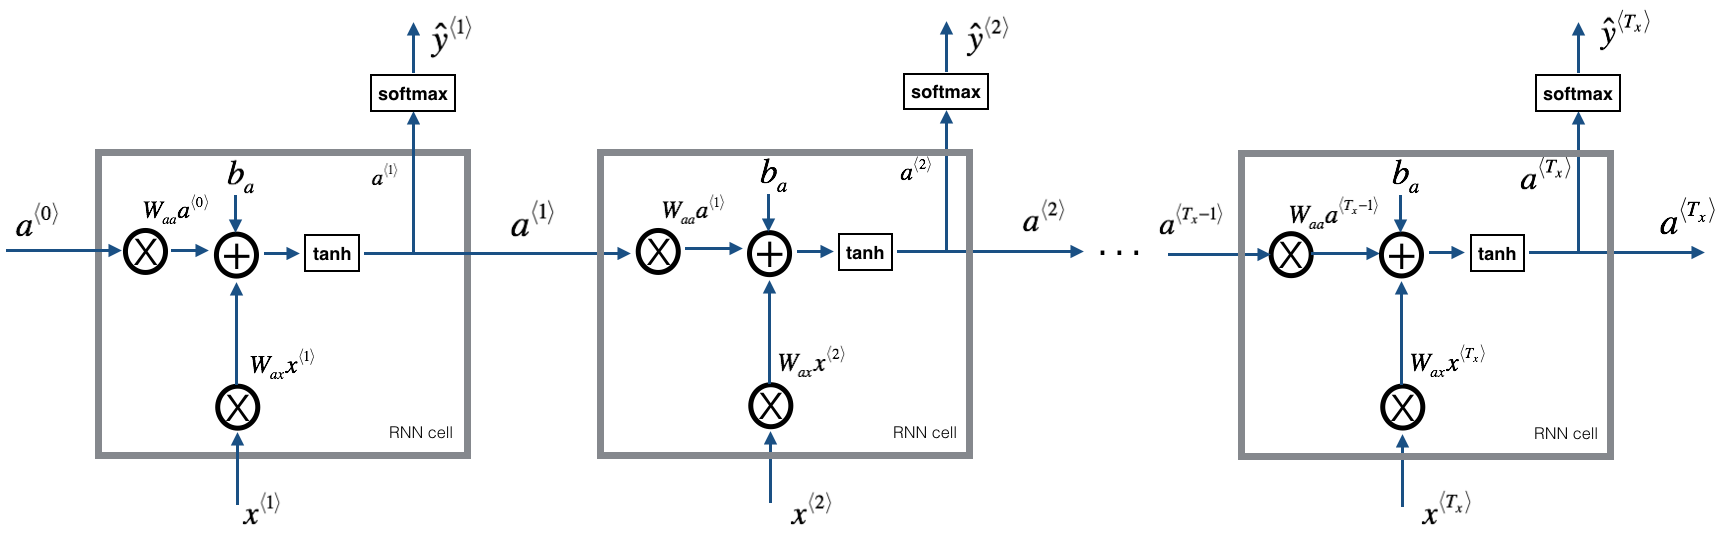

<center> image taken directly from the course site </center>

We consider the following steps to achieve that:
1. Forward propagate through the RNN blocks to compute the loss
2. Backward propagate through the RNN blocks to compute the gradients of the loss with respect to the parameters
3. Clip the gradients if necessary to avoid exploding gradients
4. Update the parameters using gradient descent

The corresponding methods for steps 1, 2, and 4 are provided in the python script utils.py, taken directly from the [course site](https://www.coursera.org/learn/nlp-sequence-models) with minimal modifications. Also see my original implementation of [forward propagation for RNN and LSTM blocks](https://github.com/rfjd/Machine-Learning/blob/master/course-projects/DLSpecialization/DLS-Sequence-Models/RNN_by_numpy/RNN-LSTM-numpy.ipynb). Below we write a function for step 3, and then an optimizer.

In [7]:
def clip(gradients, maxValue):
    """
    INPUT:
    gradients: python hashmap containing the gradients "dWax", "dWaa", "dWya", "dba", "dby"
    maxValue: cap on the magnitude of the gradients
    
    OUTPUT: 
    gradients: python hashmap with containing the clipped gradients
    """
    gradients = copy.deepcopy(gradients)
    dWax, dWaa, dWya, dba, dby = gradients['dWax'], gradients['dWaa'], gradients['dWya'], gradients['dba'], gradients['dby']
   
    for gradient in [dWax, dWaa, dWya, dba, dby]:
        np.clip(gradient, -maxValue, maxValue, out = gradient)
    
    gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "dba": dba, "dby": dby}
    
    return gradients

In [8]:
# Tests taken directly from the course site with minor changes
def clip_test(target, mValue):
    print(f"\nGradients for mValue={mValue}")
    np.random.seed(3)
    dWax = np.random.randn(5, 3) * 10
    dWaa = np.random.randn(5, 5) * 10
    dWya = np.random.randn(2, 5) * 10
    dba = np.random.randn(5, 1) * 10
    dby = np.random.randn(2, 1) * 10
    gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "dba": dba, "dby": dby}

    gradients2 = target(gradients, mValue)
    print("gradients[\"dWaa\"][1][2] =", gradients2["dWaa"][1][2])
    print("gradients[\"dWax\"][3][1] =", gradients2["dWax"][3][1])
    print("gradients[\"dWya\"][1][2] =", gradients2["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients2["dba"][4])
    print("gradients[\"dby\"][1] =", gradients2["dby"][1])
    
    for grad in gradients2.keys():
        valuei = gradients[grad]
        valuef = gradients2[grad]
        mink = np.min(valuef)
        maxk = np.max(valuef)
        assert mink >= -abs(mValue), f"Problem with {grad}. Set a_min to -mValue in the np.clip call"
        assert maxk <= abs(mValue), f"Problem with {grad}.Set a_max to mValue in the np.clip call"
        index_not_clipped = np.logical_and(valuei <= mValue, valuei >= -mValue)
        assert np.all(valuei[index_not_clipped] == valuef[index_not_clipped]), f" Problem with {grad}. Some values that should not have changed, changed during the clipping process."
    
    print("\033[92mAll tests passed!\x1b[0m")
    
clip_test(clip, 10)
clip_test(clip, 5)


Gradients for mValue=10
gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]
All tests passed!

Gradients for mValue=5
gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [5.]
gradients["dby"][1] = [5.]
All tests passed!


In [9]:
def optimize(x_indices, yhat_indices, a0, parameters, learning_rate = 0.01):
    """
    This function executes one step of gradient descent to train the model.
    
    INPUT:
    x_indices: list of indices for inputs x, each corresponding to a char via the index_to_char hashmap
    yhat_indices: list of indices for the predictions yhat, each corresponding to a char via the index_to_char hashmap
    a0: initialized hidden state
    parameters: hashmap:
                    Wax: shape = (n_a, n_x)
                    Waa: shape = (n_a, n_a)
                    Wya: shape = (n_y, n_a)
                    ba:  shape = (n_a, 1)
                    by:  shape = (n_y, 1)
    learning_rate: learning rate for the gradient descent
    
    OUTPUT:
    loss: value of the loss function (cross-entropy)
    gradients: hashmap:
                   dWax: shape = (n_a, n_x)
                   dWaa: shape = (n_a, n_a)
                   dWya: shape = (n_y, n_a)
                   dba:  shape = (n_a, 1)
                   dby:  shape = (n_y, 1)
    a[len(x_indices)-1]: the last hidden state; shape = (n_a,1)
    """
    
    loss, cache = rnn_forward(x_indices, yhat_indices, a0, parameters)
    gradients, a = rnn_backward(x_indices, yhat_indices, parameters, cache)
    gradients = clip(gradients, 5)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    return loss, gradients, a[len(x_indices)-1]

In [10]:
# Tests taken directly from the course site with minor changes
def optimize_test(target):
    np.random.seed(1)
    char_size, n_a = 27, 100
    a_prev = np.random.randn(n_a, 1)
    Wax, Waa, Wya = np.random.randn(n_a, char_size), np.random.randn(n_a, n_a), np.random.randn(char_size, n_a)
    ba, by = np.random.randn(n_a, 1), np.random.randn(char_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
    X = [12, 3, 5, 11, 22, 3]
    Y = [4, 14, 11, 22, 25, 26]
    old_parameters = copy.deepcopy(parameters)
    loss, gradients, a_last = target(X, Y, a_prev, parameters, learning_rate = 0.01)
    print("Loss =", loss)
    print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
    print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
    print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients["dba"][4])
    print("gradients[\"dby\"][1] =", gradients["dby"][1])
    print("a_last[4] =", a_last[4])
    
    assert np.isclose(loss, 126.5039757), "Problems with the call of the rnn_forward function"
    for grad in gradients.values():
        assert np.min(grad) >= -5, "Problems in the clip function call"
        assert np.max(grad) <= 5, "Problems in the clip function call"
    assert np.allclose(gradients['dWaa'][1, 2], 0.1947093), "Unexpected gradients. Check the rnn_backward call"
    assert np.allclose(gradients['dWya'][1, 2], -0.007773876), "Unexpected gradients. Check the rnn_backward call"
    assert not np.allclose(parameters['Wya'], old_parameters['Wya']), "parameters were not updated"
    
    print("\033[92mAll tests passed!")

optimize_test(optimize)

Loss = 126.50397572165363
gradients["dWaa"][1][2] = 0.19470931534722233
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.0077738760320040625
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]
All tests passed!


# <span style="color:blue"> Simultaneous Training & Sampling </span>

**Quick notes:**
1. We make a list of all examples `examples = [x for x in data.split("\n")]` that includes all individual dinosau names. We shuffle the list
2. Then for each iteration, we get a single example from this list. We will rach to the end of list if `num_iterations` is large, so we use `j % n_e-1` to find the index in the list, where `j` is the iteration index and `n_e` is the number of dinosaur names in the list.
3. If the model was perfectly trained, then the predictions $\hat{y}^{\langle t\rangle}$ would always be the same as the input sample but with a shift. For example, you can have something like this:

`x_indices = [None, 10, 9, 14, 26, 8, 15, 21, 19, 1, 21, 18, 21, 19]`

`yhat_indices = [10, 9, 14, 26, 8, 15, 21, 19, 1, 21, 18, 21, 19, 0]`

Note that the first index in `x_indices` is meaningless since we always initialize the first input $x^{\langle0\rangle}$ to a vector of zeros. Also note that `yhat_indices` ends with `0`, index of the end of line token. The `loss` can be computes by
$$loss=-\sum_{t=0}^{T_x-1}\ln\left(\hat{y}^{\langle t\rangle}_{j[t]}\right),$$
where $j[t]\equiv$ `yhat_indices[t]` is the index corresponding to the true character from the training data set at this time.

4. Having `x_indices` and `yhat_indices`, we can run one step of gradient descent to calculate loss and update parameters.
5. Every 2000 iterations we sample some dinosaur names.

In [11]:
def model(data, index_to_char, char_to_index, num_iterations = 35000, n_a = 50, num_dino_names = 7, char_size = 27, verbose = False):
    """
    INPUT:
    data_x: list of words (dinosaur names)
    index_to_char: python dictionary mapping each index to a character
    char_to_index: python dictionary mapping each character to an index
    num_iterations: number of iterations for training
    n_a: number of units of the RNN block
    num_dino_names: number of dinosaur names to sample at each iteration 
    char_size: number of unique characters found in the text
    
    OUTPUT:
    parameters: learned parameters (hashmap)
    """
    
    n_x = n_y = char_size
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # list of individual dinosaur names
    examples = [x for x in data.split("\n")]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state
    a0 = np.zeros((n_a, 1))
    
    for j in range(num_iterations):
        # find the index in the examples
        n_e = len(examples)
        idx = j % n_e-1
        
        # access the corresponding example
        # create a list of indices for this specific example: x_indices
        single_example = examples[idx]
        single_example_chars = [c for c in single_example]
        single_example_index = []
        for c in single_example_chars:
            single_example_index.append(char_to_index[c])
        x_indices = [None]+single_example_index
        
        # construct yhat_indices by shifting the x_indices and adding an end of line token
        ix_newline = char_to_index['\n']
        yhat_indices = x_indices[1:]+[ix_newline]

        # Gradient descent step
        loss, gradients, a0 = optimize(x_indices, yhat_indices, a0, parameters, learning_rate = 0.01)

        if j % 2000 == 0:
            
            print(f"Iteration {j}")
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(num_dino_names):
                sampled_indices = sample(parameters, char_to_index, seed)
                last_dino_name = get_sample(sampled_indices, index_to_char)
                print(last_dino_name.replace('\n', ''))
                seed += 1
            print('\n')
        
    return parameters, last_dino_name

In [12]:
parameters, last_name = model(data, index_to_char, char_to_index, 20001, verbose = True)

Iteration 0
Nkzxwtdmfqoeyhsqwasjkjvu
Knfb
Kzxwtdmfqoeyhsqwasjkjvu
Nfb
Zxwtdmfqoeyhsqwasjkjvu
Fb
Xwtdmfqoeyhsqwasjkjvu


Iteration 2000
Livtps
Hledaishhaclrisaurus
Hytosaurus
Lda
Xusgdmeronxdoskarnherocisaurur
A
Tos


Iteration 4000
Mivrosaurus
Inee
Ivusanonosaurus
Mcaagosaurus
Xusichisaurus
Cabasgia
Toraperlethosecongisagrusggebheltala


Iteration 6000
Onvus
Lieebesimachusankosaurus
Lwtrolongrawiros
Peeakosaurus
Xusteplosaurus
Eeajosaurus
Trohieroptisaurus


Iteration 8000
Onwusicheromurus
Kilaberthabroseraptor
Lutrodlesaurus
Oma
Xutrcherontisaurus
Edalson
Trrasaurus


Iteration 10000
Onvosaurosaurosaurus
Jicaaeropa
Kwsroeoheraveritasaurus
Olaaesaura
Xtrocephodsauroasaurus
Daadosaurus
Tosaurus


Iteration 12000
Phwusaurus
Lledanosaurus
Lxuskandonex
Pedanosaurus
Yusoeratops
Eealosaurus
Tosaurus


Iteration 14000
Onyus
Inda
Jytrodon
Olaacor
Yusperdon
Ceaeropadrysaurus
Trochisaurus


Iteration 16000
Meusisaurus
Indaceros
Itrus
Macalosaurus
Ytronnashaurus
Caaerosaurus
Trpandon


Iteration 